In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from math import log10, sqrt
from IPython.display import Image, display

from skimage.metrics import structural_similarity as ssim

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.optimizers import Adam
from keras.utils import plot_model






In [8]:
# !cat /proc/meminfo

From [0-255] to [-1,1]

In [9]:
# this "normalize" function takes an image as input and transforms its pixel values to be within the range of [-1, 1], which is a common range for neural network input data.
def normalize(image):
  return(image/255 -0.5)*2

#his function is essentially the reverse of the previous normalize function you shared. It takes a normalized image (which typically has pixel values in the range [-1, 1]) and converts it back to a standard image format with pixel values in the range [0, 255].
def to_image(normalized_image):
  return((normalized_image/2 +0.5)*255).astype(np.uint8)

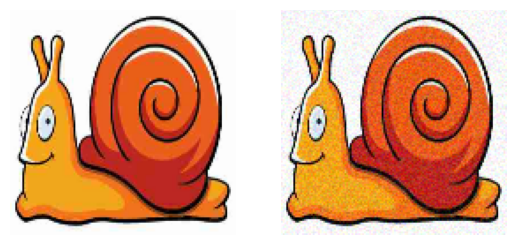

In [10]:
im= cv2.imread("snail.jpg")[:,:,::-1] #BGR TO RGB
im= cv2.resize(im,(128,128))
noise_intensity= 25
noise= np.random.randint(-noise_intensity,noise_intensity,size=im.shape)
im_noise= (im+noise).clip(0,255).astype(np.uint8)

#to ensure that the image is in 8 bit format suitable for imshow function
plt.subplot(121); plt.axis('off'); plt.imshow(to_image(normalize(im))) # line sets up the first subplot with a grid of 1 row and 2 columns and selects the first subplot (i.e., the left subplot).
plt.subplot(122); plt.axis('off'); plt.imshow(im_noise)
plt.show()

In [11]:
def plot_encoder(encoder, filename='encoder.png'):
    plot_model(encoder, to_file=filename, show_shapes=True, show_layer_names=True)

def plot_decoder(decoder, filename='decoder.png'):
    plot_model(decoder, to_file=filename, show_shapes=True, show_layer_names=True)

def deep_image_prior_model():
  encoding_size=128

#This encoder is designed to take input data with a shape of 128x128x3 (typically an RGB image) and encode it into a 128-dimensional vector
  encoder= Sequential([
      # 32 filters, each of 3*3 size, same padding:padding applied
      Convolution2D(32, 3, padding='same', input_shape=[128,128,3],activation='relu'),
      Convolution2D(32, 3, padding='same', activation='relu'),
      #reducing size of feature maps, downsampling pool size 2*2, stride=2, reduce spatial dimensions by half
      AveragePooling2D(),
      Convolution2D(64, 3, padding='same', activation='relu'),
      Convolution2D(64, 3, padding='same', activation='relu'),
      AveragePooling2D(),
      Convolution2D(128, 3, padding='same', activation='relu'),
      Convolution2D(128, 3, padding='same', activation='relu'),
      Flatten(),
      Dense(encoding_size, activation='tanh') #latent representation
    ])

  decoder= Sequential([
        Dense(192, input_shape=(encoding_size,), activation='relu'),
        Reshape((8,8,3)),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Convolution2D(128, 3, padding='same', activation='relu'),
        #Upsampling increases the spatial dimensions of an image or feature map
        UpSampling2D(),
        Convolution2D(64, 3, padding='same', activation='relu'),
        Convolution2D(64, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(32, 3, padding='same', activation='relu'),
        Convolution2D(32, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(16, 3, padding='same', activation='relu'),
        Convolution2D(16, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(8, 3, padding='same', activation='relu'),
        Convolution2D(3, 3, padding='same', activation='tanh')
])

#   encoder1= Sequential([
#       # 32 filters, each of 3*3 size, same padding:padding applied
#       Convolution2D(32, 3, padding='same', input_shape=[128,128,3],activation='relu'),
#       Convolution2D(32, 3, padding='same', activation='relu'),
#       #reducing size of feature maps, downsampling pool size 2*2, stride=2, reduce spatial dimensions by half
#       AveragePooling2D(),
#       Convolution2D(64, 3, padding='same', activation='relu'),
#       Convolution2D(64, 3, padding='same', activation='relu'),
#       AveragePooling2D(),
#       Convolution2D(128, 3, padding='same', activation='relu'),
#       Convolution2D(128, 3, padding='same', activation='relu'),
#       Flatten(),
#       Dense(encoding_size, activation='tanh') #latent representation
#     ])

#   decoder1= Sequential([
#         Dense(192, input_shape=(encoding_size,), activation='relu'),
#         Reshape((8,8,3)),
#         Convolution2D(128, 3, padding='same', activation='relu'),
#         Convolution2D(128, 3, padding='same', activation='relu'),
#         #Upsampling increases the spatial dimensions of an image or feature map
#         UpSampling2D(),
#         Convolution2D(64, 3, padding='same', activation='relu'),
#         Convolution2D(64, 3, padding='same', activation='relu'),
#         UpSampling2D(),
#         Convolution2D(32, 3, padding='same', activation='relu'),
#         Convolution2D(32, 3, padding='same', activation='relu'),
#         UpSampling2D(),
#         Convolution2D(16, 3, padding='same', activation='relu'),
#         Convolution2D(16, 3, padding='same', activation='relu'),
#         UpSampling2D(),
#         Convolution2D(8, 3, padding='same', activation='relu'),
#         Convolution2D(3, 3, padding='same', activation='tanh')
# ])


  autoencoder= Sequential([encoder,decoder])

  autoencoder.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
  return autoencoder


In [12]:
model = deep_image_prior_model()

In [13]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot_encoder(model.layers[0], filename='encoder.png')
# plot_decoder(model.layers[1], filename='decoder.png')

In [14]:
# display(Image(filename='decoder.png'))

Adding this extra dimension can be useful when working with deep learning models, especially if you want to process a single image as if it were part of a batch. Many deep learning frameworks expect input data to have a batch dimension, even if the batch size is 1.

In [15]:
#This line generates a random NumPy array x with the same shape as im but with an additional dimension of size 1 added at the beginning. The additional dimension is created by (1,). The values in x are drawn from a uniform distribution between -1 and 1 using the expression * 2 - 1. So, x contains random values in the range [-1, 1].
x = np.random.random(size=((1,) + im.shape)) * 2 - 1
#None is used to add an additional dimension to the im_noise array.
y = normalize(im_noise[None, :])
[x.shape, y.shape]

[(1, 128, 128, 3), (1, 128, 128, 3)]

Fit Noisy Image and Produce Rectified Image

In [16]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [17]:
def calculate_ssim(image1, image2):
    # Convert the images to grayscale, as SSIM is usually calculated on grayscale images
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM value
    ssim_value, _ = ssim(gray_image1, gray_image2, full=True)

    return ssim_value

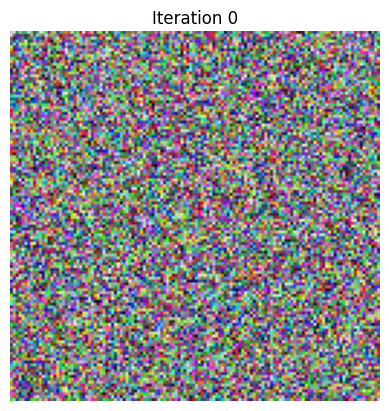

1/1 [==============================] - 0s 355ms/step
PSNR value is 28.253101520372248 dB


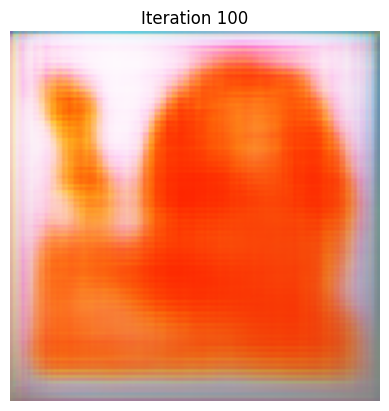

1/1 [==============================] - 0s 19ms/step
PSNR value is 28.708151880921303 dB


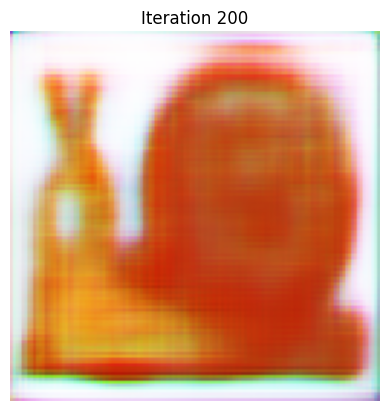

1/1 [==============================] - 0s 19ms/step
PSNR value is 29.30051170261395 dB


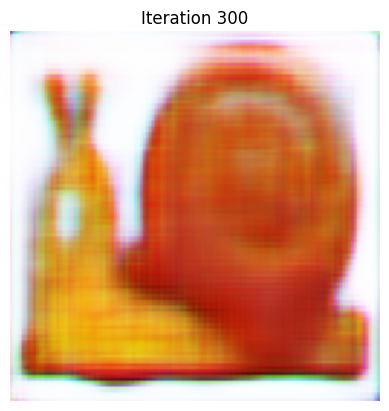

1/1 [==============================] - 0s 29ms/step
PSNR value is 29.450426287363562 dB


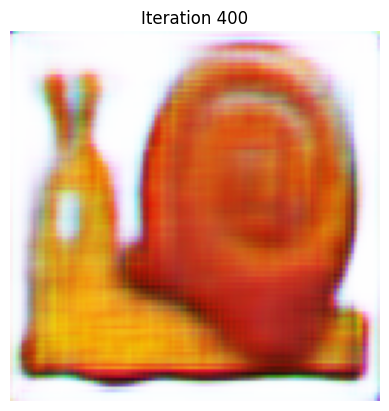

1/1 [==============================] - 0s 20ms/step
PSNR value is 29.72053669628258 dB


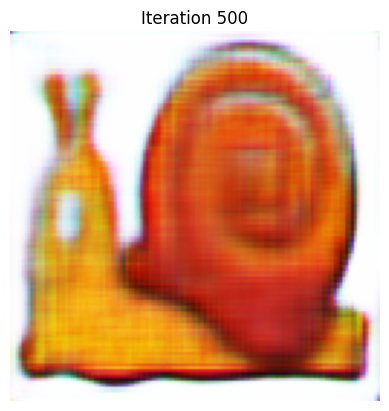

1/1 [==============================] - 0s 19ms/step
PSNR value is 29.822757987074503 dB


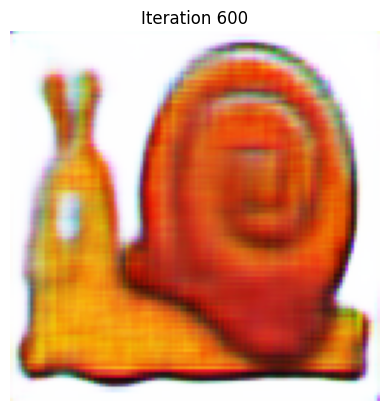

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.05326751324143 dB


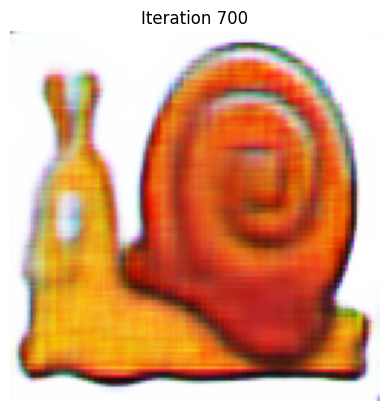

1/1 [==============================] - 0s 21ms/step
PSNR value is 30.107356941034542 dB


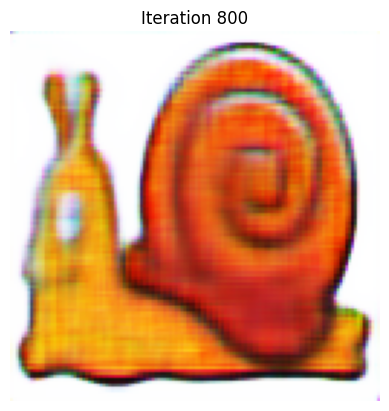

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.130374471600987 dB


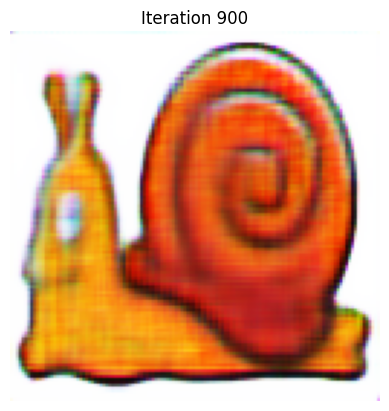

1/1 [==============================] - 0s 21ms/step
PSNR value is 30.18329250411727 dB


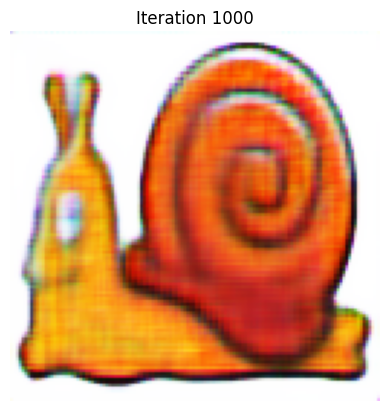

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.073487561380627 dB


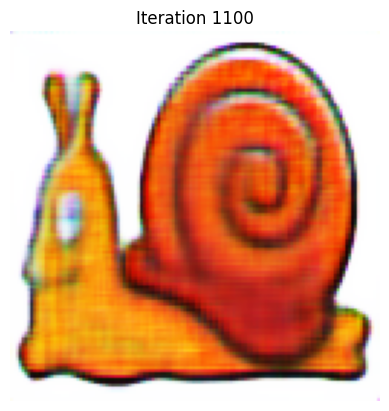

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.05513459229202 dB


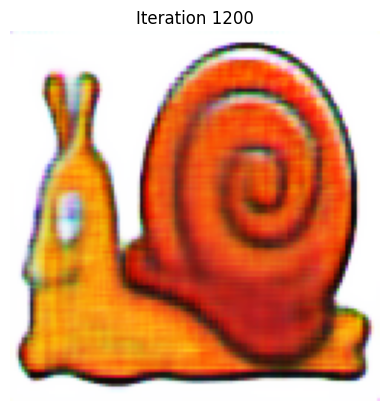

1/1 [==============================] - 0s 29ms/step
PSNR value is 30.162352809939016 dB


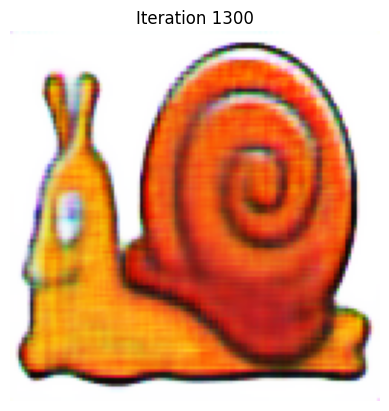

1/1 [==============================] - 0s 18ms/step
PSNR value is 30.225850801238327 dB


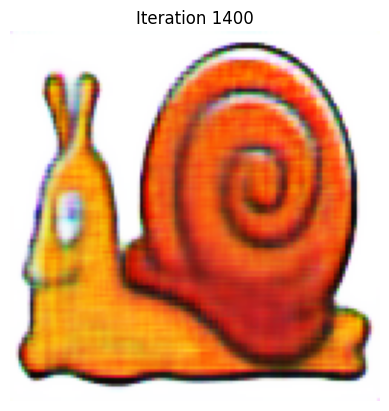

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.175888658730543 dB


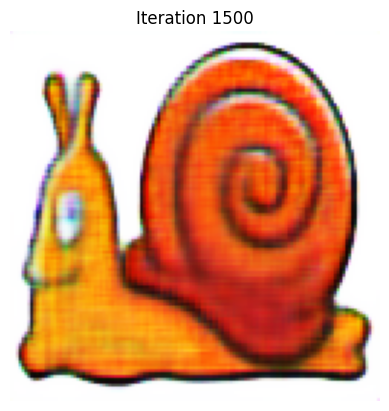

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.298460232744 dB


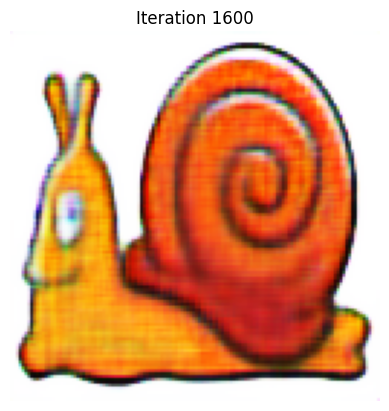

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.313038101555403 dB


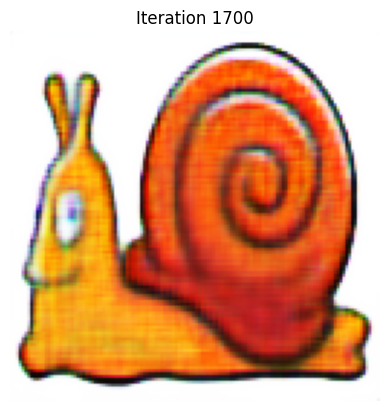

1/1 [==============================] - 0s 26ms/step
PSNR value is 30.33945187720077 dB


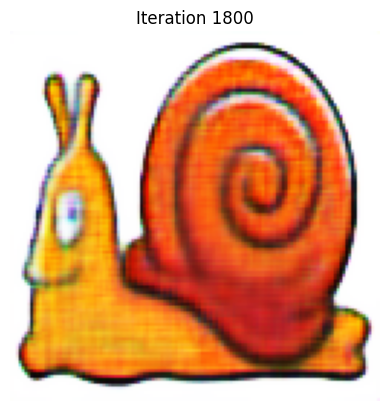

1/1 [==============================] - 0s 19ms/step
PSNR value is 30.332586899157995 dB


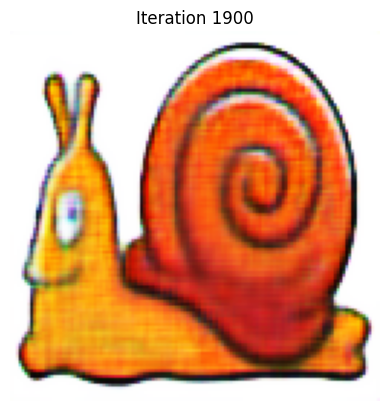

1/1 [==============================] - 0s 18ms/step
PSNR value is 30.347519899428967 dB


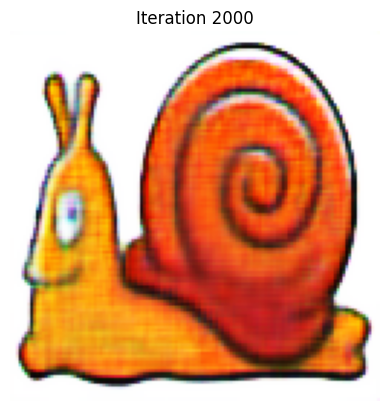

In [18]:
plt.axis('off')
plt.title('Iteration 0')
plt.imshow(to_image(x[0]))
plt.show()


iterations =20              # in hundreds
results = np.empty(x.shape)
epochs_l=[]
psnr_l= []


for i in range(iterations):
  model.fit(x,y, epochs=100, batch_size=1, verbose=0)
  output= model.predict(x)
  psnr= PSNR(im,to_image(output[0]))
  psnr_l.append(psnr)
  epochs_l.append(i*100)
  print(f"PSNR value is {psnr} dB")
  results = np.append(results, output, axis=0)
  plt.axis('off')
  plt.title('Iteration '+ str((i+1)*100))
  plt.imshow(to_image(output[0]))
  plt.show()

PSNR value is 29.589092859428 dB
PSNR value is 30.347519899428967 dB


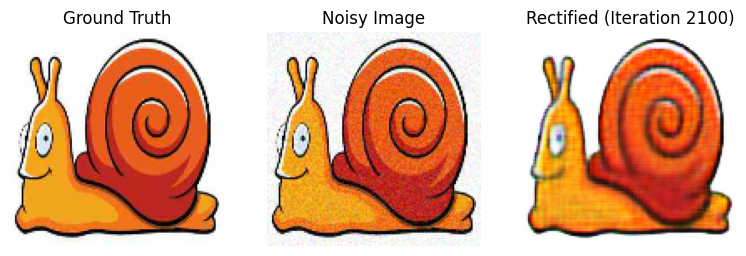

In [19]:
plt.figure(figsize=(16,6))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(im)
plt.subplot(152); plt.axis('off'); plt.title('Noisy Image'); plt.imshow(im_noise)
# i=10; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
# i=16; plt.subplot(154); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
i=20; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
psnr= PSNR(im,im_noise)
print(f"PSNR value is {psnr} dB")
psnr= PSNR(im,to_image(results[20]))
print(f"PSNR value is {psnr} dB")
plt.show()

In [20]:
image1 = im
image2 = to_image(results[20])

# Calculate SSIM value
ssim_value = calculate_ssim(image1, image2)
print(ssim_value)

0.753209510656015


Text(0, 0.5, 'PSNR')

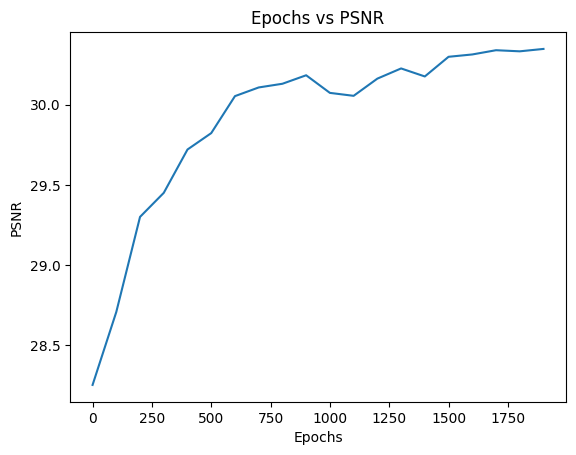

In [21]:
plt.plot(epochs_l, psnr_l)
plt.title('Epochs vs PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')